# Prediciendo reclamos de seguro vehicular

Este notebook está basado en el proyecto "Predicting insurance claim outcomes" de DataCamp, y forma parte de la trayectoria de cursos "Científico de datos asociado en Pyhton" en dicha plataforma. 

Una empresa de seguros vehiculares ha pedido construir un modelo para predecir si un cliente hará un reclamo de su seguro durante el periodo de póliza. Ya que tienen poco experiencia e infraestructura para desplegar y monitorear modelos de aprendizaje automático, han solicitado identificar la característica individual que resulte en el modelo de mejor desempeño medido por exactitud (accuracy), de modo tal que puedan empezar producción con un modelo simple.

La empresa ha enviado los datos de sus clientes en un archivo csv llamado `car_insurance.csv`, junto con una tabla que detalla los nombres de las columnas y sus respectivas descripciones, tal como se muestra a continuación:



## El conjunto de datos

| Columna | Descripción |
|--------|-------------|
| `id` | Identificador único de cliente |
| `age` | Edad del cliente: <br> <ul><li>`0`: 16-25</li><li>`1`: 26-39</li><li>`2`: 40-64</li><li>`3`: 65+</li></ul> |
| `gender` | Género del cliente: <br> <ul><li>`0`: Femenino</li><li>`1`: Masculino</li></ul> |
| `driving_experience` | Años que el cliente lleva conduciendo: <br> <ul><li>`0`: 0-9</li><li>`1`: 10-19</li><li>`2`: 20-29</li><li>`3`: 30+</li></ul> |
| `education` | Nivel de educación del cliente: <br> <ul><li>`0`: Sin educación</li><li>`1`: Secundaria</li><li>`2`: Universidad</li></ul> |
| `income` | Nivel económico del cliente: <br> <ul><li>`0`: Pobreza</li><li>`1`: Clase trabajadora</li><li>`2`: Clase media</li><li>`3`: Clase alta</li></ul> |
| `credit_score` | Puntaje crediticio del cliente (entre cero y uno) |
| `vehicle_ownership` | Estado de pertenencia del vehículo del cliente: <br><ul><li>`0`: No es dueño de su vehículo</li><li>`1`: Es dueño de su vehículo</li></ul> |
| `vehcile_year` | Año de registro del vehículo: <br><ul><li>`0`: Antes de 2015</li><li>`1`: 2015 o después</li></ul> |
| `married` | Estado civil del cliente: <br><ul><li>`0`: Soltero</li><li>`1`: Casado</li></ul> |
| `children` | Número de hijos del cliente |
| `postal_code` | Código postal del cliente | 
| `annual_mileage` | Número de millas conducidas por el cliente cada año |
| `vehicle_type` | Tipo de vehículo: <br> <ul><li>`0`: Sedan</li><li>`1`: Deportivo</li></ul> |
| `speeding_violations` | Número total de faltas del cliente por exceso de velocidad | 
| `duis` | Número de veces que el cliente ha sido detenido conduciendo bajo la influencia del alcohol |
| `past_accidents` | Número total de accidentes en los que el cliente estuvo involucrado |
| `outcome` | Si el cliente hizo un reclamo por su seguro vehicular o no (**variable respuesta**): <br><ul><li>`0`: No hizo un reclamo</li><li>`1`: Hizo un reclamo</li></ul> |

## Importación y limpieza de datos

Empezamos importando los módulos requeridos para el análisis:

In [1]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit
import matplotlib.pyplot as plt
import seaborn as sns

Importamos los datos del archivo csv y visualizamos las primeras 5 filas:

In [ ]:
path = '' # specify the path to your data files
insurance = pd.read_csv(path + 'car_insurance.csv')
insurance.head()

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,0,1,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,0,0,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,0,1,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,1,1,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


Podemos ver que algunas columnas tienen datos categóricos, los cuales deberíamos trabsformar a variable numéricas para asegurar el rendimiento de los modelos. Para ello creamos unos diccionarios y los mapeamos a las columnas correspondientes:

In [3]:
experience_dict = {'0-9y': 0, '10-19y': 1, '20-29y': 2, '30y+': 3}
education_dict = {'none': 0, 'high school': 1, 'university': 2}
income_dict = {'poverty': 0, 'working class': 1, 'middle class': 2, 'upper class': 3}
vehicleyear_dict = {'before 2015': 0, 'after 2015': 1}
vehicletype_dict = {'sedan': 0, 'sports car': 1}

In [4]:
insurance['driving_experience'] = insurance['driving_experience'].map(experience_dict)
insurance['education'] = insurance['education'].map(education_dict)
insurance['income'] = insurance['income'].map(income_dict)
insurance['vehicle_year'] = insurance['vehicle_year'].map(vehicleyear_dict)
insurance['vehicle_type'] = insurance['vehicle_type'].map(vehicletype_dict)
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  int64  
 2   gender               10000 non-null  int64  
 3   driving_experience   10000 non-null  int64  
 4   education            10000 non-null  int64  
 5   income               10000 non-null  int64  
 6   credit_score         9018 non-null   float64
 7   vehicle_ownership    10000 non-null  float64
 8   vehicle_year         10000 non-null  int64  
 9   married              10000 non-null  float64
 10  children             10000 non-null  float64
 11  postal_code          10000 non-null  int64  
 12  annual_mileage       9043 non-null   float64
 13  vehicle_type         10000 non-null  int64  
 14  speeding_violations  10000 non-null  int64  
 15  duis                 10000 non-null  

In [5]:
insurance.head()

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0,1,3,0.629027,1.0,1,0.0,1.0,10238,12000.0,0,0,0,0,0.0
1,750365,0,1,0,0,0,0.357757,0.0,0,0.0,0.0,10238,16000.0,0,0,0,0,1.0
2,199901,0,0,0,1,1,0.493146,1.0,0,0.0,0.0,10238,11000.0,0,0,0,0,0.0
3,478866,0,1,0,2,1,0.206013,1.0,0,0.0,1.0,32765,11000.0,0,0,0,0,0.0
4,731664,1,1,1,0,1,0.388366,1.0,0,0.0,0.0,32765,12000.0,0,2,0,1,1.0


Tras imprimir información sobre las columnas, así como volver a imprimir las primeras 5 filas, verificamos que ahora todos los datos son numéricos. Ahora podemos contar los distintos valores de nuestra variable objetivo, `outcome`:

In [6]:
insurance['outcome'].value_counts()

outcome
0.0    6867
1.0    3133
Name: count, dtype: int64

Podemos ver que aproximadamente un tercio de todos los clientes en el conjunto de datos realizaron un reclamo de su seguro vehicular. Este dato nos servirá para comprender algunos resultados más adelante.

## Definiendo funciones para evaluar métricas

La consulta de la empresa solicita hallar la variable que da el mejor rendimiento medido por exactitud. Sin embargo, podemos comparar distintas métricas y ver cómo se comparan los modelos según cada una. Compararemos la exactitud, sensibilidad y especificidad, así como el valor ROC AUC, el área bajo la curva ROC (Receiver Operating Characteristic), la cual mide cómo responden distintas métricas ante cambios en el valor del umbral de decisión.

Empezamos definiendo una función para calcular la exactitud, sensibilidad y especificidad de un modelo a partir de la matriz de confusión resultante:

In [7]:
def get_metrics(conf_matrix):
    accuracy = (conf_matrix[0,0]+conf_matrix[1,1])/(conf_matrix[0,0]+conf_matrix[1,1]+conf_matrix[1,0]+conf_matrix[0,1])
    sensitivity = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[1,0])
    specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    return accuracy, sensitivity, specificity

La siguiente función calcula, para varios umbrales de decisión, las tasas de verdaderos positivos y de falsos positivos, las cuales forman la curva ROC:

In [8]:
def roc(model):
    thresholds = np.linspace(0,1.,21)
    tpr = []
    fpr = []
    for threshold in thresholds:
        conf_matrix = model.pred_table(threshold=threshold)
        sensitivity = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[1,0])
        specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        tpr.append(sensitivity)
        fpr.append(1-specificity)
    return fpr, tpr

La siguiente función calcula el área debajo de una curva aleatoria dada por una serie de puntos coordenados (x,y). Esta será usada para calcular el área bajo la curva ROC:

In [9]:
def auc(x,y): # calculate area under curve using trapezoid method
    assert len(x) == len(y)
    data = pd.DataFrame({'x':x,'y':y}).sort_values('x') # make sure values are correctly sorted
    x = data['x'].values
    y = data['y'].values
    areas = [(y[i]+y[i+1])*(x[i+1]-x[i])/2 for i in range(len(x)-1)]
    return sum(areas)

## Seleccionando variables y construyendo modelos

Ahora seleccionamos las variable que serán usadas individualmente para generar los modelos de predicción que vamos a evaluar. Estas variables corresponden a todas las columnas del conjunto de datos excepto el identificador de cada cliente y la variable de respuesta:

In [10]:
cols = insurance.drop(['id','outcome'],axis=1).columns.values
print(cols)

['age' 'gender' 'driving_experience' 'education' 'income' 'credit_score'
 'vehicle_ownership' 'vehicle_year' 'married' 'children' 'postal_code'
 'annual_mileage' 'vehicle_type' 'speeding_violations' 'duis'
 'past_accidents']


Ahora creamos listas vacías para almacenar los valores de las distintas métricas que compararemos. Para cada característica que seleccionamos, creamos un modelo de regresión logística y lo ajustamos a los datos, generamos la matriz de confusión, y calculamos las métricas, las cuales almacenamos en los arreglos creados previamente.

In [11]:
accuracies = []
sensitivities = []
specificities = []
auc_values = []

for column in cols:
    # create model instance and fit to data
    model = logit(f'outcome ~ {column}',insurance).fit()
    # get confusion matrix
    conf_matrix = model.pred_table()
    # calculate accuracy: sum of diagonal elements divided by total sum of elements
    accuracy, sensitivity, specificity = get_metrics(conf_matrix)
    # calculate roc curve and auc
    fpr, tpr = roc(model)
    auc_value = auc(fpr,tpr)
    # append metric values to lists
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    auc_values.append(auc_value)

Optimization terminated successfully.
         Current function value: 0.511794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.615951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467390
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.603848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.552412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.586659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595431
  

Ahora que tenemos todos los valores de las métricas los podemos agregar a un DataFrame con los nombres de la variable para compararlos fácilmente:

In [12]:
features_df = pd.DataFrame({'feature':cols,'accuracy':accuracies,'sensitivity':sensitivities,'specificity':specificities,'auc':auc_values})
print(features_df)

                feature  accuracy  sensitivity  specificity       auc
0                   age  0.774700     0.462177     0.917286  0.769057
1                gender  0.686700     0.000000     1.000000  0.557783
2    driving_experience  0.777100     0.707628     0.808796  0.808000
3             education  0.686700     0.000000     1.000000  0.607520
4                income  0.742500     0.378551     0.908548  0.744600
5          credit_score  0.706698     0.255567     0.912910  0.702244
6     vehicle_ownership  0.735100     0.560804     0.814621  0.687712
7          vehicle_year  0.686700     0.000000     1.000000  0.645772
8               married  0.686700     0.000000     1.000000  0.641269
9              children  0.686700     0.000000     1.000000  0.616204
10          postal_code  0.686700     0.000000     1.000000  0.567199
11       annual_mileage  0.693354     0.036655     0.989411  0.609518
12         vehicle_type  0.686700     0.000000     1.000000  0.500000
13  speeding_violati

## Comparando modelos por exactitud

Podemos ordenar las características en el DataFrame en orden descendente por exactitud, y seleccionar la característica con mayor exactitud:

In [13]:
print(features_df.sort_values('accuracy',ascending=False))
best_feature_by_accuracy = features_df.sort_values('accuracy',ascending=False).reset_index(drop=True).head(1)
best_feature_by_accuracy = best_feature_by_accuracy[['feature','accuracy']]
best_feature_by_accuracy.rename(columns={'feature':'best_feature','accuracy':'best_accuracy'},inplace=True)
print('\n',best_feature_by_accuracy)

                feature  accuracy  sensitivity  specificity       auc
2    driving_experience  0.777100     0.707628     0.808796  0.808000
0                   age  0.774700     0.462177     0.917286  0.769057
4                income  0.742500     0.378551     0.908548  0.744600
6     vehicle_ownership  0.735100     0.560804     0.814621  0.687712
5          credit_score  0.706698     0.255567     0.912910  0.702244
11       annual_mileage  0.693354     0.036655     0.989411  0.609518
1                gender  0.686700     0.000000     1.000000  0.557783
3             education  0.686700     0.000000     1.000000  0.607520
7          vehicle_year  0.686700     0.000000     1.000000  0.645772
8               married  0.686700     0.000000     1.000000  0.641269
9              children  0.686700     0.000000     1.000000  0.616204
10          postal_code  0.686700     0.000000     1.000000  0.567199
12         vehicle_type  0.686700     0.000000     1.000000  0.500000
13  speeding_violati

Vemos que la característica con mayor exactitud es `driving_experience`, o el timepo que el cliente lleva conduciendo, con una exactitud de 0.7771. Esta característica coincide con aquella de mejor sensibilidad. Todas aquellos modelos con sensibilidad igual a 0 tienen una exactitud constante de 0.6867. Esto tiene sentido si recordamos la distribución de la variable respuesta: 6867 negativos y 3133 positivos. Si un modelo asigna negativo a cualquier valor de la característica de entrada, entonces dicho modelo encontrará 6867 verdaderos negativos y 0 verdaderos positivos, lo cual lleva a una exactitud de 0.6867 en esta muestra de 10 000 datos. Podemos mostrar las gráficas del ajuste de regresión logística de algunos modelos para comparar modelos de buen desempeño, como aquellos basados en `driving_experience` y `income`, con modelos de mal desempeño como quellos basados en `education` y `postal_code`. Como era de esperar, las dos curvas de regresión inferiores siempre se encuentran por debajo del umbral de decisión de 0.5, por lo que los modelos respectivos asignan un valor de 0 a la variable respuesta independientemente del valor de la variable de entrada, lo cual lleva a un mal desempeño medido por exactitud o por sensibilidad.

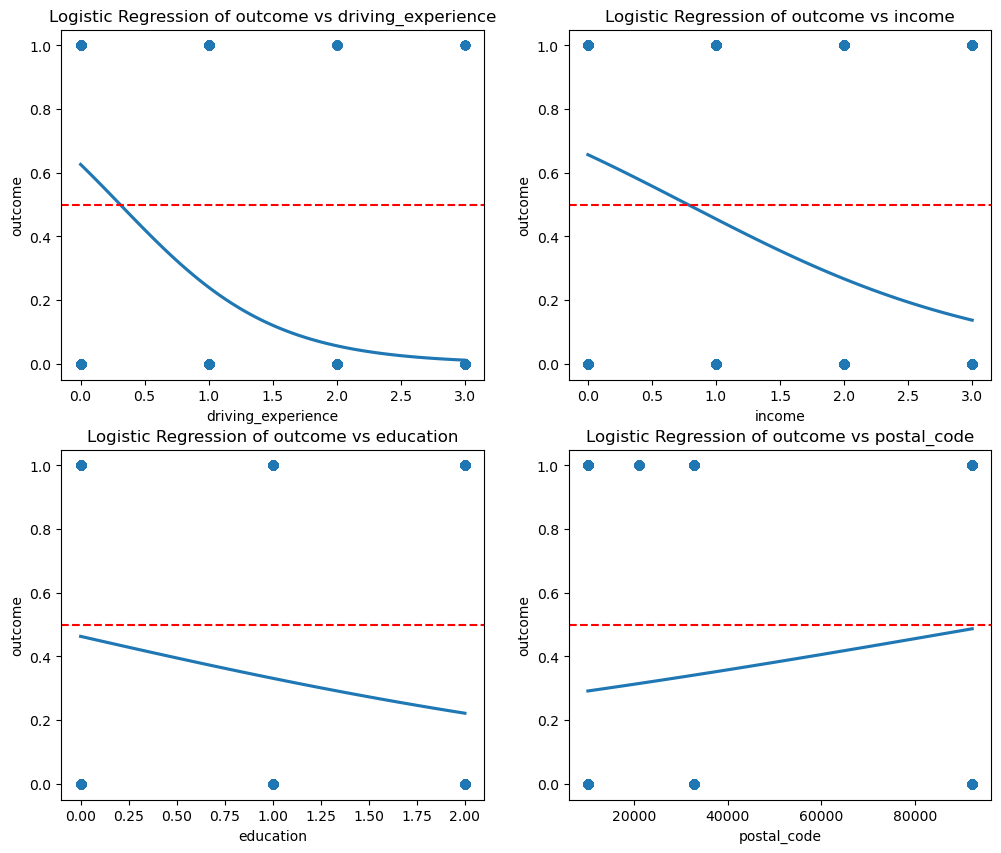

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
for axis, feature in zip(ax.flatten(), ['driving_experience','income','education','postal_code']):
    sns.regplot(x=feature, y='outcome', data=insurance, logistic=True, ci=None, ax=axis)
    axis.axhline(0.5, color='red', linestyle='--')
    axis.set_title(f'Logistic Regression of outcome vs {feature}')
plt.show()

## Comparando modelos por ROC AUC

También podemos ordenar las características en el DataFrame en orden descendente por valor de AUC, y seleccionar la característica con mayor valor:

In [16]:
print(features_df.sort_values('auc',ascending=False))
best_feature_by_auc = features_df.sort_values('auc',ascending=False).reset_index(drop=True).head(1)
best_feature_by_auc = best_feature_by_auc[['feature','auc']]
best_feature_by_auc.rename(columns={'feature':'best_feature','auc':'best_auc'},inplace=True)
print('\n',best_feature_by_auc)

                feature  accuracy  sensitivity  specificity       auc
2    driving_experience  0.777100     0.707628     0.808796  0.808000
0                   age  0.774700     0.462177     0.917286  0.769057
4                income  0.742500     0.378551     0.908548  0.744600
13  speeding_violations  0.686700     0.000000     1.000000  0.718266
15       past_accidents  0.686700     0.000000     1.000000  0.712393
5          credit_score  0.706698     0.255567     0.912910  0.702244
6     vehicle_ownership  0.735100     0.560804     0.814621  0.687712
7          vehicle_year  0.686700     0.000000     1.000000  0.645772
8               married  0.686700     0.000000     1.000000  0.641269
9              children  0.686700     0.000000     1.000000  0.616204
11       annual_mileage  0.693354     0.036655     0.989411  0.609518
3             education  0.686700     0.000000     1.000000  0.607520
14                 duis  0.686700     0.000000     1.000000  0.586849
10          postal_c

En este caso la característica que lleva al modelo de mayor AUC es nuevamente `driving_experience`, con un valor de ROC AUC de 0.808. Este es un valor suficientemente cercano a 1 para indicar que se trata de un buen modelo, justo lo que buscamos. Además de comparar los valores de AUC, podemos visualizar las curvas ROC para algunos modelos de buen y mal rendimiento: 

Optimization terminated successfully.
         Current function value: 0.467390
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.567469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.603848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621700
         Iterations 5


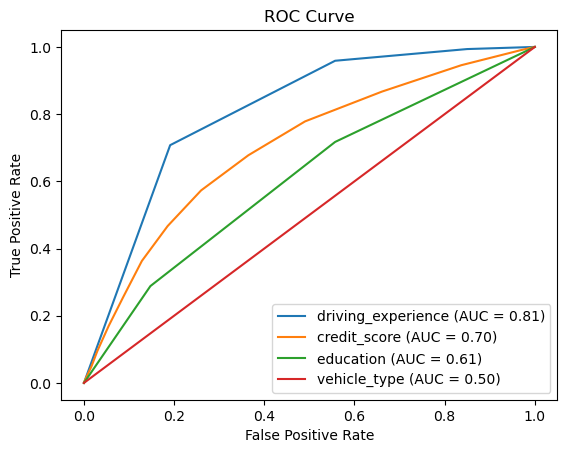

In [17]:
for feature in ['driving_experience','credit_score','education','vehicle_type']:
    # create model instance and fit to data
    model = logit(f'outcome ~ {feature}',insurance).fit()
    fpr, tpr = roc(model)
    plt.plot(fpr,tpr,label=feature + f' (AUC = {auc(fpr,tpr):.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Nótese que el modelo de `driving_experience` tiene la mayor área bajo la curva ROC, y es por tanto el de mejor desempeño. Por otro lado, el modelo de `vehicle_type` tiene un área bajo la curva ROC de 0.5, lo cual es indistinguible de un modelo que asigna valores al azar, y por lo tanto tiene mal desempeño.

## Conclusiones

Hemos visto cómo es posible comparar el desempeño de varios modelos usando distintas métricas. En este caso, cada modelo está basado en una única variable de entrada para seleccionar aquella que genera el modelo de mejor desempeño, lo cual es útil cuando no es posible depender de modelos muy complejos. En este caso, tanto usando la métrica de exactitud como el área bajo la curva ROC nos da `driving_experience` como la característica que resulta en el modelo de mejor rendimiento.